# parPE steadystate example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create sbml model from scratch
!./createSteadystateExampleSBML.py > model_steadystate_scaled.sbml

In [3]:
sbml_file = 'model_steadystate_scaled.sbml'
model_name = 'model_steadystate_scaled'
model_output_dir= 'model_steadystate_scaled'

In [4]:
# Show model info
import libsbml
SBMLreader = libsbml.SBMLReader()
sbml_doc = SBMLreader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['x1', 'x2', 'x3']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


## Generate model code

In [5]:
observables = []
fixed_parameters = ['k0']

def createModule(sbml_model_file, model_name, model_output_dir):
    """Create Python module from SBML model"""
    sbmlImporter = amici.SbmlImporter(sbml_model_file)
    sbml = sbmlImporter.sbml
    global observables
    observables = amici.assignmentRules2observables(sbml, filter=lambda variableId: 
                                                    variableId.startswith('observable_') and not variableId.endswith('_sigma'))
    
    print(observables)
    print(fixed_parameters)

    sbmlImporter.sbml2amici(model_name,
                            output_dir=model_output_dir,
                            observables=observables,
                            constantParameters=fixed_parameters,
                            sigmas={'observable_x1withsigma': 'observable_x1withsigma_sigma'})


createModule(sbml_file, model_name, model_output_dir)



{'observable_x1': 'x1', 'observable_x2': 'x2', 'observable_x3': 'x3', 'observable_x1_scaled': 'scaling_x1 * x1', 'observable_x2_offsetted': 'offset_x2 + x2'}
['k0']


## Test simulation

In [6]:
def plotStateTrajectories(rdata):
    for ix in range(rdata['x'].shape[1]):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


{'t': array([ 0.        ,  1.01694915,  2.03389831,  3.05084746,  4.06779661,
        5.08474576,  6.10169492,  7.11864407,  8.13559322,  9.15254237,
       10.16949153, 11.18644068, 12.20338983, 13.22033898, 14.23728814,
       15.25423729, 16.27118644, 17.28813559, 18.30508475, 19.3220339 ,
       20.33898305, 21.3559322 , 22.37288136, 23.38983051, 24.40677966,
       25.42372881, 26.44067797, 27.45762712, 28.47457627, 29.49152542,
       30.50847458, 31.52542373, 32.54237288, 33.55932203, 34.57627119,
       35.59322034, 36.61016949, 37.62711864, 38.6440678 , 39.66101695,
       40.6779661 , 41.69491525, 42.71186441, 43.72881356, 44.74576271,
       45.76271186, 46.77966102, 47.79661017, 48.81355932, 49.83050847,
       50.84745763, 51.86440678, 52.88135593, 53.89830508, 54.91525424,
       55.93220339, 56.94915254, 57.96610169, 58.98305085, 60.        ]), 'x': array([[0.1       , 0.4       , 0.7       ],
       [0.57995051, 0.73365809, 0.0951589 ],
       [0.55996496, 0.71470091, 0

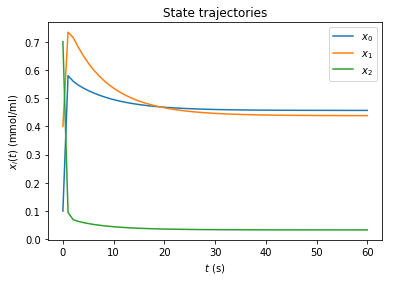

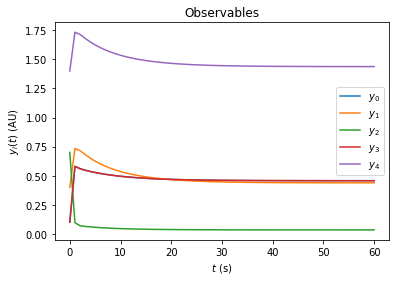

In [7]:
# load model
sys.path.insert(0, model_output_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 60, 60))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

print(rdata)

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Create in silico experimental data for parameter estimation

In [8]:
expectedLlh = 0.0

def createData():
    # setup model & solver
    model = modelModule.getModel()
    model.setTimepoints(amici.DoubleVector(np.linspace(0, 60, 60)))
    print('True parameters: ', np.array(model.getParameters()))
    
    solver = model.getSolver()
    solver.setMaxSteps(10000)

    # generate conditon-vectors
    conditions = [np.array(model.getFixedParameters())]
    #conditions.append(conditions[0] * 1.5)
    
    conditionDf = createConditionDataframe(fixed_parameters, conditions)
    
    df = pd.DataFrame(data={
        'observable': [],
        'condition': [],
        'conditionRef': [],
        'scalingParameter': [],
        'time': [],
        'measurement': [],
        'sigma': []
    })

    global expectedLlh
    for icondition, condition in enumerate(conditions):      
        print('Condition %d: %s' % (icondition, condition))
        rdata = getReturnDataForCondition(model, solver, condition)
        
        print('\tllh: ', rdata['llh'])
        expectedLlh += rdata['llh']
        
        # Append data
        for iy, observableName in enumerate(observables.keys()):
            df = df.append(pd.DataFrame(
            {'observable': [observableName] * model.nt(),
             'condition': ['condition-%d' % icondition] * model.nt(),
             'conditionRef': ['condition-%d' % icondition] * model.nt(),
             'scalingParameter': [''] * model.nt(),
             'time': np.array(model.getTimepoints()),
             'measurement': rdata['y'][:, iy],
             'sigma': [1.0] * model.nt()
             }), ignore_index=True)
    print('Expected llh: ', expectedLlh)
            
    return df, conditionDf


def createConditionDataframe(fixed_parameters, conditions):
    """Create dataframe with fixed-parameters for each condition to simulate"""
    conditionDf = pd.DataFrame(index = fixed_parameters)
    conditionDf['ID'] = conditionDf.index
    for icondition, condition in enumerate(conditions):
        conditionDf['condition-%d' % icondition] = condition
    
    return conditionDf


def getReturnDataForCondition(model, solver, condition):
    # simulate without measurements
    edata = amici.ExpData(model.get())
    edata.fixedParameters = amici.DoubleVector(condition)
    edata.my = amici.DoubleVector(np.full(shape=model.nt() * model.nytrue, fill_value=np.nan))
    rdata = amici.runAmiciSimulation(model, solver, edata)        
    # fixedParametersPreequilibration = 
    
    # confirm gradient is 0 for real measurements and save expected llh
    edata.my = amici.DoubleVector(rdata['y'].flatten())
    edata.sigmay = amici.DoubleVector(np.ones(shape=rdata['y'].shape).flatten())

    solver.setSensitivityMethod(amici.AMICI_SENSI_FSA)
    solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_FIRST)
    model.requireSensitivitiesForAllParameters()
    rdata = amici.runAmiciSimulation(model, solver, edata)
    print('\tsllh', rdata['sllh'])
    
    return rdata

df, conditionDf = createData()

True parameters:  [1.  0.5 0.4 2.  0.1 1.  1. ]
Condition 0: [1.]
	sllh [ 6.47109678e-08 -5.17948679e-07 -1.38485149e-07  8.95072631e-08
  2.19249607e-06  6.67619185e-08  3.42709685e-07]
	llh:  -275.68155996140223
Expected llh:  -275.68155996140223


In [9]:
df

,condition,conditionRef,measurement,observable,scalingParameter,sigma,time
0,condition-0,condition-0,0.100000,observable_x1,,1.0,0.000000
1,condition-0,condition-0,0.579951,observable_x1,,1.0,1.016949
2,condition-0,condition-0,0.559965,observable_x1,,1.0,2.033898
3,condition-0,condition-0,0.546285,observable_x1,,1.0,3.050847
4,condition-0,condition-0,0.535619,observable_x1,,1.0,4.067797
5,condition-0,condition-0,0.526365,observable_x1,,1.0,5.084746
6,condition-0,condition-0,0.518220,observable_x1,,1.0,6.101695
7,condition-0,condition-0,0.511038,observable_x1,,1.0,7.118644
8,condition-0,condition-0,0.504700,observable_x1,,1.0,8.135593
9,condition-0,condition-0,0.499107,observable_x1,,1.0,9.152542


In [10]:
conditionDf

,ID,condition-0
k0,k0,1.0


In [11]:
# write data frames to file
measurement_file = 'example_data.tsv'
fixed_parameter_file = 'example_data_fixed.tsv'
hdf5File = 'example_data.h5'

df.to_csv(measurement_file, sep='\t', index=False)
conditionDf.to_csv(fixed_parameter_file, sep='\t', index=False)

# convert to HDF5
import subprocess
out = subprocess.run(['%s/generateHDF5DataFileFromText.py' % os.path.join(os.getcwd(), '..', '..', '..', 'misc'),
    hdf5File,
    sbml_file,
    model_output_dir,
    measurement_file,
    fixed_parameter_file], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
print(out)
print(out.stdout.decode("utf-8"))
assert out.returncode==0


CompletedProcess(args=['/home/dweindl/src/parPE/amici/examples/steadystate/../../../misc/generateHDF5DataFileFromText.py', 'example_data.h5', 'model_steadystate_scaled.sbml', 'model_steadystate_scaled', 'example_data.tsv', 'example_data_fixed.tsv'], returncode=0, stdout=b'Cost shape (300, 7)\nChanging t = Inf to t = 1e8.\nNum conditions:  1\nNum timepoints:  60 [0.0, 1.0169491525423728, 2.0338983050847457, 3.0508474576271185, 4.067796610169491, 5.084745762711863, 6.101694915254238, 7.118644067796611, 8.135593220338983, 9.152542372881355, 10.169491525423727, 11.186440677966099, 12.203389830508476, 13.220338983050848, 14.237288135593221, 15.254237288135593, 16.271186440677965, 17.28813559322034, 18.305084745762716, 19.322033898305087, 20.338983050847453, 21.355932203389827, 22.372881355932197, 23.38983050847457, 24.40677966101695, 25.423728813559322, 26.440677966101696, 27.457627118644066, 28.474576271186443, 29.49152542372881, 30.508474576271187, 31.525423728813557, 32.54237288135593, 3

In [12]:
# todo: pscale, preeequilibration

In [13]:
# write true parameters as first starting point, an perturbed additional points
# two times the same point to check for reproducibility
true_parameters = np.array(model.getParameters())
import h5py
with h5py.File(hdf5File, 'r+') as f:
    for i in range(10):
        parameters = true_parameters * (1.1 + i * 0.01)
        parameters = np.log10(parameters)
        f['/optimizationOptions/randomStarts'][:,2*i]   = parameters
        f['/optimizationOptions/randomStarts'][:,2*i+1] = parameters


In [14]:
# enable derivate checker
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test first-order
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test_print_all yes
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                hierarchicalOptimization            1
                               numStarts            1
                       retryOptimization            1
                ceres/max_num_iterations          100
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acceptable_obj_change_tol        1e-18
   ipopt/watchdog_shortened_iter_trigger            0
                   ipopt/derivative_test b'first-order'
         ipopt/derivative_test_print_all       b'yes'
                          toms611/mxfcal  100000000.0


## Optimize

In [15]:
!pwd
!../../../build/amici/examples/steadystate/example_steadystate_multi  -o deleteme/ example_data.h5


/home/dweindl/src/parPE/amici/examples/steadystate
[2018-06-09 13:03:36] [DBG] [-1/] MPI not initialized.
[2018-06-09 13:03:36] [DBG] [-1/] Seeding RNG with 1528542216
[2018-06-09 13:03:36] [DBG] [-1/] Writing results to deleteme/_rank-0001.h5.
[2018-06-09 13:03:36] [DBG] [-1/] Starting runParallelMultiStartOptimization with 1 starts sequentially
[2018-06-09 13:03:36] [INF] [-1/] Reading random initial theta 0 from /optimizationOptions/randomStarts
HierachicalOptimizationWrapper: 0 proportionality factors, 0 offset parameters
[2018-06-09 13:03:36] [DBG] [-1/] Set optimization option acceptable_iter to 1.
[2018-06-09 13:03:36] [DBG] [-1/] Set optimization option acceptable_obj_change_tol to 1.0000000000000001e-18.
[2018-06-09 13:03:36] [DBG] [-1/] Set optimization option acceptable_tol to 1e+20.
[2018-06-09 13:03:36] [DBG] [-1/] Set optimization option derivative_test to first-order.
[2018-06-09 13:03:36] [DBG] [-1/] Set optimization option derivative_test_print_all to yes.
[2018-06-09 

[2018-06-09 13:03:36] [DBG] [-1/] Result for 0.0.0.0 (0): -275.683 (0) (0.0439s)
[2018-06-09 13:03:36] [INF] [-1/] iter: 6 cost: 275.683 time_iter: 0.0559996s time_optim: 0.61438s
   6  2.7568279e+02 0.00e+00 9.42e-02  -8.5 2.59e-03    -  1.00e+00 1.00e+00f  1
[2018-06-09 13:03:36] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:37] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0409s)
[2018-06-09 13:03:37] [INF] [-1/] iter: 7 cost: 275.682 time_iter: 0.0534716s time_optim: 0.667852s
   7  2.7568244e+02 0.00e+00 1.21e-01 -10.3 3.49e-03    -  1.00e+00 1.00e+00f  1
[2018-06-09 13:03:37] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0016s)
[2018-06-09 13:03:37] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0376s)
[2018-06-09 13:03:37] [INF] [-1/] iter: 8 cost: 275.682 time_iter: 0.0499342s time_optim: 0.717787s
   8  2.7568235e+02 0.00e+00 1.39e-01 -11.0 2.33e-03    -  1.00e+00 1.00e+00f  1
[2018-06-09 13:03:37] [DBG] [-1/] Result for 0.0.0.0 

[2018-06-09 13:03:37] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0421s)
[2018-06-09 13:03:37] [INF] [-1/] iter: 20 cost: 275.682 time_iter: 0.0742282s time_optim: 1.50633s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.7568178e+02 0.00e+00 5.12e-02 -11.0 2.29e-02    -  1.00e+00 1.25e-01f  4
[2018-06-09 13:03:37] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0019s)
[2018-06-09 13:03:37] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0447s)
[2018-06-09 13:03:37] [INF] [-1/] iter: 21 cost: 275.682 time_iter: 0.0597823s time_optim: 1.56611s
  21  2.7568161e+02 0.00e+00 5.73e-02 -11.0 3.32e-02    -  1.00e+00 1.00e+00f  1
[2018-06-09 13:03:37] [DBG] [-1/] Result for 0.0.0.0 (0): -276.003 (0) (0.0014s)
[2018-06-09 13:03:37] [DBG] [-1/] Result for 0.0.0.0 (0): -276.003 (0) (0.0020s)
[2018-06-09 13:03:37] [DBG] [-1/] Result for 0.0.0.0 (0): -276.003 (0) (0.0019s)
[2018-06-09 13:03:37] [DBG] [-1/] Result for 0.0.0.0 (0): -276.003 (0) 

[2018-06-09 13:03:38] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0017s)
[2018-06-09 13:03:38] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0019s)
[2018-06-09 13:03:38] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0019s)
[2018-06-09 13:03:38] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:38] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0557s)
[2018-06-09 13:03:38] [INF] [-1/] iter: 30 cost: 275.682 time_iter: 0.0859173s time_optim: 2.39796s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.7568157e+02 0.00e+00 6.19e-03 -11.0 8.94e-04    -  1.00e+00 5.00e-01f  2
[2018-06-09 13:03:38] [DBG] [-1/] Result for 0.0.0.0 (0): -275.683 (0) (0.0017s)
[2018-06-09 13:03:38] [DBG] [-1/] Result for 0.0.0.0 (0): -275.683 (0) (0.0015s)
[2018-06-09 13:03:38] [DBG] [-1/] Result for 0.0.0.0 (0): -275.683 (0) (0.0020s)
[2018-06-09 13:03:38] [DBG] [-1/] Result for 0.0.0.0 (0): -275.683 (0) (0.0015s)
[2018-06-

[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.683 (0) (0.0018s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0483s)
[2018-06-09 13:03:39] [INF] [-1/] iter: 37 cost: 275.682 time_iter: 0.100781s time_optim: 3.01174s
  37  2.7568157e+02 0.00e+00 1.72e-02  -9.5 1.46e+00    -  1.00e+00 2.44e-04f 13
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.683 (0) (0.0015s)
[2018-06-0

[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0395s)
[2018-06-09 13:03:39] [INF] [-1/] iter: 43 cost: 275.682 time_iter: 0.0906064s time_optim: 3.51904s
  43  2.7568156e+02 0.00e+00 2.40e-03 -10.9 1.17e+00    -  1.00e+00 9.77e-04f 11
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0017s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:39] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-

[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0437s)
[2018-06-09 13:03:40] [INF] [-1/] iter: 50 cost: 275.682 time_iter: 0.0916075s time_optim: 4.10338s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.7568156e+02 0.00e+00 5.96e-04 -11.0 3.35e-02    -  1.00e+00 7.81e-03f  8
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0017s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0018s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0016s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-

[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0408s)
[2018-06-09 13:03:40] [INF] [-1/] iter: 56 cost: 275.682 time_iter: 0.0800315s time_optim: 4.61309s
  56  2.7568156e+02 0.00e+00 5.11e-04 -11.0 2.56e-03    -  1.00e+00 1.56e-02f  7
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0017s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0018s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0019s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:40] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-

[2018-06-09 13:03:41] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0344s)
[2018-06-09 13:03:41] [INF] [-1/] iter: 63 cost: 275.682 time_iter: 0.0726587s time_optim: 5.213s
  63  2.7568156e+02 0.00e+00 3.28e-04 -11.0 6.18e-04    -  1.00e+00 3.12e-02f  6
[2018-06-09 13:03:41] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:41] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0013s)
[2018-06-09 13:03:41] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0013s)
[2018-06-09 13:03:41] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:41] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0013s)
[2018-06-09 13:03:41] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0013s)
[2018-06-09 13:03:41] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:41] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0013s)
[2018-06-09 13:03:41] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0013s)
[2018-06-09

[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0394s)
[2018-06-09 13:03:42] [INF] [-1/] iter: 69 cost: 275.682 time_iter: 0.0661395s time_optim: 5.68925s
  69  2.7568156e+02 0.00e+00 2.60e-04 -11.0 9.20e-05    -  1.00e+00 2.50e-01f  3
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0014s)
[2018-06-

[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0020s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0020s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0017s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0460s)
[2018-06-09 13:03:42] [INF] [-1/] iter: 75 cost: 275.682 time_iter: 0.108121s time_optim: 6.3378s
  75  2.7568156e+02 0.00e+00 1.35e-04 -11.0 3.38e-03    -  1.00e+00 9.77e-04f 11
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0022s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0018s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0019s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0020s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0016s)
[2018-06-09 13:03:42] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0017s)
[2018-06-09

[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0016s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0017s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0021s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0020s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0018s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0020s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0020s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0490s)
[2018-06-09 13:03:43] [INF] [-1/] iter: 81 cost: 275.682 time_iter: 0.109624s time_optim: 6.97562s
  81  2.7568156e+02 0.00e+00 7.46e-05 -11.0 2.31e-03    -  1.00e+00 1.95e-03f 10
[2018-06-0

[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0500s)
[2018-06-09 13:03:43] [INF] [-1/] iter: 87 cost: 275.682 time_iter: 0.114072s time_optim: 7.56582s
  87  2.7568156e+02 0.00e+00 4.57e-05 -11.0 6.96e-02    -  1.00e+00 4.88e-04f 12
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0016s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0019s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0020s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0021s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0022s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0018s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0016s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0017s)
[2018-06-09 13:03:43] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0018s)
[2018-06-0

[2018-06-09 13:03:44] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0419s)
[2018-06-09 13:03:44] [INF] [-1/] iter: 93 cost: 275.682 time_iter: 0.0952466s time_optim: 8.14104s
  93  2.7568156e+02 0.00e+00 1.25e-05 -11.0 2.20e-03    -  1.00e+00 3.91e-03f  9
[2018-06-09 13:03:44] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0018s)
[2018-06-09 13:03:44] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0017s)
[2018-06-09 13:03:44] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0019s)
[2018-06-09 13:03:44] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0019s)
[2018-06-09 13:03:44] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0021s)
[2018-06-09 13:03:44] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0016s)
[2018-06-09 13:03:44] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0017s)
[2018-06-09 13:03:44] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:44] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0016s)
[2018-06-

[2018-06-09 13:03:45] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0472s)
[2018-06-09 13:03:45] [INF] [-1/] iter: 99 cost: 275.682 time_iter: 0.109635s time_optim: 8.73741s
  99  2.7568156e+02 0.00e+00 5.30e-06 -11.0 7.53e-03    -  1.00e+00 9.77e-04f 11
[2018-06-09 13:03:45] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0016s)
[2018-06-09 13:03:45] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0022s)
[2018-06-09 13:03:45] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0015s)
[2018-06-09 13:03:45] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0017s)
[2018-06-09 13:03:45] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0020s)
[2018-06-09 13:03:45] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0020s)
[2018-06-09 13:03:45] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0020s)
[2018-06-09 13:03:45] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0022s)
[2018-06-09 13:03:45] [DBG] [-1/] Result for 0.0.0.0 (0): -275.682 (0) (0.0021s)
[2018-06-0

## Compare results

In [16]:
with h5py.File('deleteme/_rank-0001.h5', 'r') as f:
    final_parameters = f['/multistarts/0/finalParameters'][:]
    exit_status = f['/multistarts/0/exitStatus'][:]
    final_cost = f['/multistarts/0/finalCost'][:]
final_parameters = np.power(10, final_parameters)

print("#  __Exp___ __Act___ __Err____")
for i in range(len(true_parameters)):
    print('%d: %6f %6f %6f' % (i, true_parameters[i], final_parameters[i], final_parameters[i]-true_parameters[i]))
print('Status: %d' % exit_status)
print('Cost: %f (expected: %f)' % (final_cost, expectedLlh))

#  __Exp___ __Act___ __Err____
0: 1.000000 1.000009 0.000009
1: 0.500000 0.500001 0.000001
2: 0.400000 0.400004 0.000004
3: 2.000000 2.000001 0.000001
4: 0.100000 0.100000 0.000000
5: 1.000000 1.000000 -0.000000
6: 1.000000 1.000000 -0.000000
Status: 1
Cost: 275.681560 (expected: -275.681560)


In [18]:
!PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deleteme/ example_data.h5


Index	Gradient	fd_f		(delta)		fd_c		(delta)		fd_b		(delta)
    0! g:      497.147 fd_f:      497.141 (Δ  0.00533442) fd_c:      497.138 (Δ   0.0080629) fd_b:      497.136 (Δ   0.0107914)fb:      2216.33 fc:      2216.33 ff:      2216.33
    1! g:     -1575.79 fd_f:     -1575.79 (Δ -0.00149644) fd_c:     -1575.79 (Δ -0.00215583) fd_b:     -1575.78 (Δ -0.00281521)fb:      2216.33 fc:      2216.33 ff:      2216.33
    2! g:     -9.63783 fd_f:     -9.63632 (Δ -0.00150585) fd_c:     -9.63694 (Δ-0.000891937) fd_b:     -9.63755 (Δ-0.000278028)fb:      2216.33 fc:      2216.33 ff:      2216.33
    3! g:      21.1294 fd_f:      21.1302 (Δ-0.000806062) fd_c:      21.1332 (Δ -0.00383013) fd_b:      21.1362 (Δ  -0.0068542)fb:      2216.33 fc:      2216.33 ff:      2216.33
    4! g:       1241.5 fd_f:      1241.51 (Δ -0.00762849) fd_c:       1241.5 (Δ -0.00449073) fd_b:       1241.5 (Δ -0.00135298)fb:      2216.33 fc:      2216.33 ff:      2216.33
    5  g:      140.532 fd_f:      140.532 (Δ-4.9026